Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Define ML problems

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict?
- [ ] Is your problem regression or classification?
- [ ] How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?
    - Regression: Is the target right-skewed? If so, you may want to log transform the target.
- [ ] Choose your evaluation metric(s).
    - Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
    - Regression: Will you use mean absolute error, root mean squared error, R^2, or other regression metrics?
- [ ] Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them?
    - Will you do a random split or a time-based split?
- [ ] Begin to clean and explore your data.
- [ ] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

If you haven't found a dataset yet, do that today. [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2) and choose your dataset.

Some students worry, ***what if my model isn't “good”?*** Then, [produce a detailed tribute to your wrongness. That is science!](https://twitter.com/nathanwpyle/status/1176860147223867393)

In [1]:
%%capture
!pip install category_encoders==2.*

# Working locally:
DATA_PATH = '../data/'

### Import Libraries

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", 75)
pd.set_option("display.max_rows", 75)

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import classification_report, roc_curve, plot_confusion_matrix, plot_roc_curve
from sklearn.model_selection import train_test_split
from category_encoders import OneHotEncoder

In [3]:
def clean_up_binary_columns(cell_contents):
  if isinstance(cell_contents, str):
    return 1
  else:
    return 0

## 1. Wrangle Data

In [179]:
def wrangle(filepath):
  df = pd.read_csv(filepath, parse_dates=['DATE'], index_col='DATE')

  # Drop Columns with a high number of NaNs
  df.dropna(axis=1, thresh=300, inplace=True)
 
  # High Cardinality Categorical Columns
  #categorical_cols = df.select_dtypes('object').columns
  #threshold = 10
  #high_card_cols = [col for col in categorical_cols if df[col].nunique() > threshold]
  #df.drop(high_card_cols, axis=1, inplace=True)

 
  
  #Feature engineering 
  #df['Total_fatalities'] = df['PERSONS KILLED'] + df['PEDESTRIANS KILLED'] + df['CYCLISTS KILLED'] + df['MOTORISTS KILLED']
  #df['Total_injured'] = df['PERSONS INJURED'] + df['PEDESTRIANS INJURED'] + df['CYCLISTS INJURED'] + df['MOTORISTS INJURED']
 # df['Total_victims'] = df['Total_fatalities'] + df['Total_injured']
  df['New_Borough'] = df['BOROUGH'].replace({'STATEN ISLAND':0, 'BRONX':0, 'MANHATTAN':0, 'QUEENS':1,'BROOKLYN':1})
  
  # Drop 'UNIQUE KEY' column
  df = df.drop(columns='UNIQUE KEY')
  df = df.drop(columns='BOROUGH')
  df= df.drop(columns=['TIME','ZIP CODE',
       'LOCATION', 'ON STREET NAME','LATITUDE', 'LONGITUDE', 'CROSS STREET NAME', 'OFF STREET NAME',
       'VEHICLE 2 TYPE', 'VEHICLE 3 TYPE', 'VEHICLE 4 TYPE', 'VEHICLE 5 TYPE',
       'VEHICLE 2 FACTOR', 'VEHICLE 3 FACTOR', 'VEHICLE 4 FACTOR', 'VEHICLE 5 FACTOR'])
  df= df.fillna(0) 
  return df

df = wrangle(DATA_PATH+'database.csv')  

print(df.shape)
df.head()

(477732, 11)


,PERSONS INJURED,PERSONS KILLED,PEDESTRIANS INJURED,PEDESTRIANS KILLED,CYCLISTS INJURED,CYCLISTS KILLED,MOTORISTS INJURED,MOTORISTS KILLED,VEHICLE 1 TYPE,VEHICLE 1 FACTOR,New_Borough
DATE,,,,,,,,,,,
2015-01-01,0,0,0,0,0,0,0,0,SPORT UTILITY/STATION WAGON,TRAFFIC CONTROL DISREGARDED,1.0
2015-01-01,1,0,0,0,0,0,1,0,PASSENGER VEHICLE,ANIMALS ACTION,0.0
2015-01-01,0,0,0,0,0,0,0,0,PASSENGER VEHICLE,FATIGUED/DROWSY,1.0
2015-01-01,0,0,0,0,0,0,0,0,BUS,LOST CONSCIOUSNESS,1.0
2015-01-01,0,0,0,0,0,0,0,0,UNKNOWN,UNSPECIFIED,0.0


In [8]:
df.columns

Index(['PERSONS INJURED', 'PERSONS KILLED', 'PEDESTRIANS INJURED',
       'PEDESTRIANS KILLED', 'CYCLISTS INJURED', 'CYCLISTS KILLED',
       'MOTORISTS INJURED', 'MOTORISTS KILLED', 'VEHICLE 1 TYPE',
       'VEHICLE 1 FACTOR', 'New_Borough'],
      dtype='object')

In [58]:
#df['BOROUGH'].value_counts()

In [180]:
# no missing values 
df.isnull().sum()

PERSONS INJURED        0
PERSONS KILLED         0
PEDESTRIANS INJURED    0
PEDESTRIANS KILLED     0
CYCLISTS INJURED       0
CYCLISTS KILLED        0
MOTORISTS INJURED      0
MOTORISTS KILLED       0
VEHICLE 1 TYPE         0
VEHICLE 1 FACTOR       0
New_Borough            0
dtype: int64

In [54]:
#df['New_Borough'] = df['BOROUGH'].replace({'STATEN ISLAND':0, 'BRONX':1, 'MANHATTAN':2, 'QUEENS':3,'BROOKLYN':4})

In [11]:
df.head(5)

,PERSONS INJURED,PERSONS KILLED,PEDESTRIANS INJURED,PEDESTRIANS KILLED,CYCLISTS INJURED,CYCLISTS KILLED,MOTORISTS INJURED,MOTORISTS KILLED,VEHICLE 1 TYPE,VEHICLE 1 FACTOR,New_Borough
DATE,,,,,,,,,,,
2015-01-01,0,0,0,0,0,0,0,0,SPORT UTILITY/STATION WAGON,TRAFFIC CONTROL DISREGARDED,1.0
2015-01-01,1,0,0,0,0,0,1,0,PASSENGER VEHICLE,ANIMALS ACTION,0.0
2015-01-01,0,0,0,0,0,0,0,0,PASSENGER VEHICLE,FATIGUED/DROWSY,1.0
2015-01-01,0,0,0,0,0,0,0,0,BUS,LOST CONSCIOUSNESS,1.0
2015-01-01,0,0,0,0,0,0,0,0,UNKNOWN,UNSPECIFIED,0.0


## 2. Split The Data 

In [181]:
target= 'New_Borough'
y = df[target]
X = df.drop(columns= target)

In [182]:
#df['DATE']. value_counts()

KeyError: 'DATE'

### Cutoff

In [183]:

cutoff = '2015-12-25'
mask = X.index < cutoff

X_train, X_vt, y_train, y_vt = train_test_split(X, y, test_size=0.8)
X_train, y_train = X.loc[mask], y.loc[mask]

start_val= '2015-12-26'
end_val= '2016-06-29'
mask_val = (X.index> start_val) & (X.index < end_val)

X_val, X_test, y_val, y_test = train_test_split(X_vt, y_vt, test_size=0.5) 
X_val, y_val, = X.loc[mask_val], y.loc[mask_val]

start_test= '2016-06-30'
end_test= '2017-12-31'
mask_test = (X.index> start_test) & (X.index < end_test)

X_test, y_test = X.loc[mask_test], y.loc[mask_test]

In [149]:
X_test


,PERSONS INJURED,PERSONS KILLED,PEDESTRIANS INJURED,PEDESTRIANS KILLED,CYCLISTS INJURED,CYCLISTS KILLED,MOTORISTS INJURED,MOTORISTS KILLED,VEHICLE 1 TYPE,VEHICLE 1 FACTOR
DATE,,,,,,,,,,
2016-07-01,0,0,0,0,0,0,0,0,VAN,UNSPECIFIED
2016-07-01,1,0,0,0,0,0,0,0,PASSENGER VEHICLE,UNSPECIFIED
2016-07-01,2,0,0,0,0,0,2,0,PASSENGER VEHICLE,UNSPECIFIED
2016-07-01,0,0,0,0,0,0,0,0,PASSENGER VEHICLE,UNSPECIFIED
2016-07-01,0,0,0,0,0,0,0,0,PASSENGER VEHICLE,UNSPECIFIED
...,...,...,...,...,...,...,...,...,...,...
2017-02-28,0,0,0,0,0,0,0,0,SPORT UTILITY/STATION WAGON,ACCELERATOR DEFECTIVE
2017-02-28,0,0,0,0,0,0,0,0,PASSENGER VEHICLE,UNSPECIFIED
2017-02-28,1,0,1,0,0,0,0,0,PASSENGER VEHICLE,FAILURE TO YIELD RIGHT-OF-WAY


In [79]:
X_train

,PERSONS INJURED,PERSONS KILLED,PEDESTRIANS INJURED,PEDESTRIANS KILLED,CYCLISTS INJURED,CYCLISTS KILLED,MOTORISTS INJURED,MOTORISTS KILLED,VEHICLE 1 TYPE,VEHICLE 1 FACTOR
DATE,,,,,,,,,,
2015-01-01,0,0,0,0,0,0,0,0,SPORT UTILITY/STATION WAGON,TRAFFIC CONTROL DISREGARDED
2015-01-01,1,0,0,0,0,0,1,0,PASSENGER VEHICLE,ANIMALS ACTION
2015-01-01,0,0,0,0,0,0,0,0,PASSENGER VEHICLE,FATIGUED/DROWSY
2015-01-01,0,0,0,0,0,0,0,0,BUS,LOST CONSCIOUSNESS
2015-01-01,0,0,0,0,0,0,0,0,UNKNOWN,UNSPECIFIED
...,...,...,...,...,...,...,...,...,...,...
2015-06-28,0,0,0,0,0,0,0,0,PASSENGER VEHICLE,BACKING UNSAFELY
2015-06-28,0,0,0,0,0,0,0,0,TAXI,UNSPECIFIED
2015-06-28,0,0,0,0,0,0,0,0,PASSENGER VEHICLE,UNSPECIFIED


## Establish Baseline

In [195]:
y_train.value_counts(normalize=True)

0.0    0.571139
1.0    0.428861
Name: New_Borough, dtype: float64

In [185]:

print("Baseline Accuracy", y_train.value_counts(normalize=True).max())

Baseline Accuracy 0.5711385339170533


## Build Model

In [194]:

ohe = OneHotEncoder(use_cat_names=True)

ohe.fit(X_train)


XT_train = ohe.transform(X_train)
XT_val= ohe.transform(X_val)
XT_test = ohe.transform(X_test)


print(XT_train.shape)
print(XT_val.shape)
print(XT_test.shape)

C:\Users\arnel\anaconda3\envs\unit2\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


(214258, 74)
(111497, 74)
(149820, 74)


In [196]:
lr_model = make_pipeline(OneHotEncoder(use_cat_names= True), 
                         SimpleImputer(), 
                         StandardScaler(),
                         LogisticRegression())

lr_model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['VEHICLE 1 TYPE', 'VEHICLE 1 FACTOR'],
                               use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [197]:
model_rf = make_pipeline(OneHotEncoder(use_cat_names= True),
                         SimpleImputer(strategy= 'mean'),
                         RandomForestClassifier())

model_rf.fit(X_train, y_train)
model_rf

C:\Users\arnel\anaconda3\envs\unit2\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['VEHICLE 1 TYPE', 'VEHICLE 1 FACTOR'],
                               use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier', RandomForestClassifier())])

In [189]:
X_val.value_counts

<bound method DataFrame.value_counts of             PERSONS INJURED  PERSONS KILLED  PEDESTRIANS INJURED  \
DATE                                                               
2015-12-27                0               0                    0   
2015-12-27                2               0                    0   
2015-12-27                0               0                    0   
2015-12-27                0               0                    0   
2015-12-27                0               0                    0   
...                     ...             ...                  ...   
2016-06-28                0               0                    0   
2016-06-28                0               0                    0   
2016-06-28                0               0                    0   
2016-06-28                0               0                    0   
2016-06-28                0               0                    0   

            PEDESTRIANS KILLED  CYCLISTS INJURED  CYCLISTS KILLED  \
DATE  

## Check the Metrics

### Accuracy

In [198]:
print("Training Accuracy - Logistic Regression", lr_model.score(X_train, y_train))
print("Validation Accuracy - Logistic Regression", lr_model.score(X_val, y_val))

Training Accuracy - Logistic Regression 0.5872266146421604
Validation Accuracy - Logistic Regression 0.5783832748863198


In [199]:
print("Training Accuracy - Random Forest", model_rf.score(X_train, y_train))
print("Validation Accuracy - Random Forest", model_rf.score(X_val, y_val))

Training Accuracy - Random Forest 0.5955623593984822
Validation Accuracy - Random Forest 0.5778989569226077


### Correlation

In [200]:
df.corr()

,PERSONS INJURED,PERSONS KILLED,PEDESTRIANS INJURED,PEDESTRIANS KILLED,CYCLISTS INJURED,CYCLISTS KILLED,MOTORISTS INJURED,MOTORISTS KILLED,New_Borough
PERSONS INJURED,1.000000,0.018667,0.275958,0.002529,0.163235,0.002152,0.861593,0.025676,0.021505
PERSONS KILLED,0.018667,1.000000,0.008535,0.740585,-0.003039,0.258293,0.017109,0.605724,-0.001393
PEDESTRIANS INJURED,0.275958,0.008535,1.000000,0.014432,-0.023372,-0.001798,-0.046758,-0.003082,0.026490
PEDESTRIANS KILLED,0.002529,0.740585,0.014432,1.000000,-0.002785,-0.000216,0.000188,-0.000415,0.000070
CYCLISTS INJURED,0.163235,-0.003039,-0.023372,-0.002785,1.000000,0.001747,-0.033929,-0.002265,0.019913
CYCLISTS KILLED,0.002152,0.258293,-0.001798,-0.000216,0.001747,1.000000,0.001850,0.010510,0.001901
MOTORISTS INJURED,0.861593,0.017109,-0.046758,0.000188,-0.033929,0.001850,1.000000,0.027977,0.002900
MOTORISTS KILLED,0.025676,0.605724,-0.003082,-0.000415,-0.002265,0.010510,0.027977,1.000000,-0.003308
New_Borough,0.021505,-0.001393,0.026490,0.000070,0.019913,0.001901,0.002900,-0.003308,1.000000


## Make sure there is no leakeage

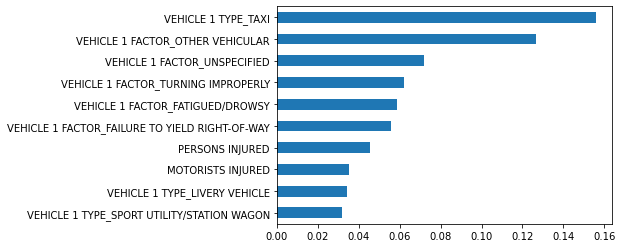

In [201]:
importances = model_rf.named_steps['randomforestclassifier'].feature_importances_
features = XT_train.columns
pd.Series(importances,index=features).abs().sort_values().tail(10).plot(kind='barh');

## Tune Model

In [206]:
model = make_pipeline(
    OneHotEncoder(use_cat_names= True),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_estimators=300,
                           n_jobs=-1)
)

model.fit(X_train, y_train);

C:\Users\arnel\anaconda3\envs\unit2\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [207]:
print('Training Accuracy:', model.score(X_train, y_train) )
print('Validation Accuracy:',model.score(X_val, y_val) )

Training Accuracy: 0.5955623593984822
Validation Accuracy: 0.5781142093509243


              precision    recall  f1-score   support

         0.0       0.60      0.82      0.69     64375
         1.0       0.50      0.25      0.33     47122

    accuracy                           0.58    111497
   macro avg       0.55      0.53      0.51    111497
weighted avg       0.56      0.58      0.54    111497



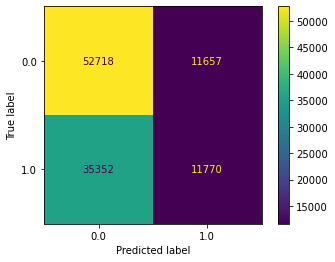

In [208]:
print(classification_report(y_val, lr_model.predict(X_val)))
plot_confusion_matrix(
    lr_model,
    X_val,
    y_val)
plt.show()
   # display_labels = ['no repairs needed','needs repairs'])

              precision    recall  f1-score   support

         0.0       0.59      0.84      0.70     64375
         1.0       0.50      0.21      0.30     47122

    accuracy                           0.58    111497
   macro avg       0.55      0.53      0.50    111497
weighted avg       0.56      0.58      0.53    111497



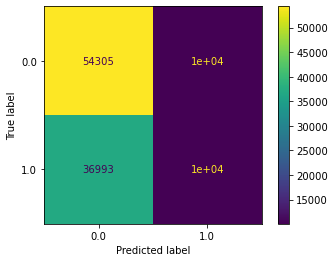

In [209]:
print(classification_report(y_val, model_rf.predict(X_val)))
plot_confusion_matrix(model_rf, X_val, y_val)
plt.show()

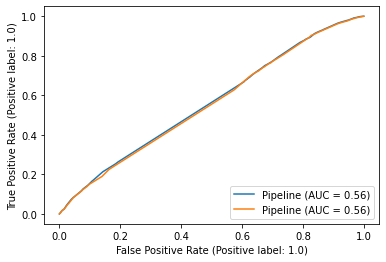

In [210]:
lr = plot_roc_curve(lr_model, X_val, y_val)
rf = plot_roc_curve(model_rf, X_val, y_val, ax=lr.ax_)